# Portfolio: Bank Loan Approval Prediction #
This is the sixth portfolio to solve the classification problem. The dataset used in this project is sourced from the data science competition sponsor by McKinsey analytics and held in a platform "Analytics Vidhya". The competition link can be found here [contest page] (https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon-ii/).

Dataset: The data source was contributed by a chain of bank customers based in US for McKinsey consulting firm. McKinsey hosted this dataset as open data science hack competition on Analytics Vidhya. The dataset consists of 26 features on anonymized customers including mixed variables (i.e., numerical and categorical) such as client ID, Loan Period, Loan Amount, Monthly Income and other customer's demographic features. The volume of dataset contains about 69,713 cases.

**Goal:** To develop a classification model predicts clients at high chances of getting a loan approval

**Results:** 83% of auc_roc score made on a test set of client population using XGBoost classifier.

**Risks:** Model incorrectly identified with 17% of error (especially error being Type I error).

**Mitigation:** Review identified cases with a group of bank account managers before making any loan approval decisions

**Next Steps for Future Work:**

1. Collection of meaningful features.
2. Model improvement: algorithms, resampling strategies and classifier designs (i.e., age specific, loan period, etc.)

**Recommendations for Clients:**

1. Implement 
2. Collect meaningful features for building an accurate model: number of payments late for mortgage, credit card, etc.

# Part 1 - DEFINE #

**Problem Statement:** 
A digital arm of a bank faces challenges with lead conversions. The primary objective of this department is to increase customer acquisition through digital channels. The department was setup a few years back and the primary focus of the department over these yeas has been to increase # of leads getting into the conversion funnel.

They source leads through channels like search, display, emali campaigns and via affiliate partners. As expected, they see differential conversion dependings on the sources and the quality of these leads. 

They now like to identify the leads' segments that have a higher conversion ratio (lead to buying a product) so they can specifically target these potential customers through additional channels and re-marketing. They have provided a partial dataset for salaried customers from the last 3 months. They also captured basic demographics about their customers. We need to identify the segment of customers with a high probability of conversion in the next 30 days.

**Stakeholders:** bank account managers, digital marketing analysts and customer sales rep.

In [1]:
# Import all libraries #
import sys
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
plt.style.use('ggplot')
import operator
from itertools import cycle
import scipy.stats as sp
from scipy import interp
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import sklearn.metrics as skm
import sklearn.base as skb
from sklearn.utils import shuffle, resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Authorship:
__author__ = 'Taesun Yoo'
__email__ = 'yoots1988@gmail.com'

# Check out Python version:
print ("Python version: {}".format(sys.version))

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Python version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


# Part 2 - DISCOVERY #

In [2]:
#############################
# Part 2 - DISCOVER PHASE ###
#############################
# --- 2. Write Out List of Functions --- #
def load_file(file):
    '''load CSV file as a dataframe'''
    df = pd.read_csv(file)
    return df

def drop_column_by_index(df, var_name):
    '''drop a column by index'''
    df = df.drop(var_name, axis=1)
    return df

def join_data(df_train, df_label, key,
              left_index=None, right_index=None):
    '''merge the feature(s) and label dataframes'''
    df_join = pd.merge(df_train, df_label, how='inner', on=key,
             left_index=False, right_index=False)
    return df_join    

def clean_data(df):
    '''drop any duplicates based on a specific column'''
    clean_df = df.drop_duplicates(subset='ID')
    return clean_df

def convert_DOB_to_age(df, var_name, date_format):
    '''set DOB as datetime and calculate age'''
    df[var_name] = pd.to_datetime(df[var_name], format=date_format)
    df[var_name] = np.where(df[var_name] > datetime.now(),
                           df[var_name] - timedelta(365*100),
                           df[var_name])
    df['Age'] = datetime.now().year - df[var_name].apply(lambda x:x.year)

def convert_date_to_columns(df, var_name, date_format):
    '''use lead creation date to create year, month, day and weekday'''
    df[var_name] = pd.to_datetime(df[var_name], format=date_format)
    df['LCD_year'] = df[var_name].apply(lambda x:x.year)
    df['LCD_month'] = df[var_name].apply(lambda x:x.month)
    df['LCD_day'] = df[var_name].apply(lambda x:x.day)
    df['LCD_weekday'] = df[var_name].apply(lambda x:x.weekday())    

def convert_dt_as_category(df):
    '''convert metadata type from object to category'''
    for var_name in df.columns:
        if df[var_name].dtype.name == 'object':
            df[var_name] = df[var_name].astype('category')

def convert_dt_as_object(df):
    '''convert metadata type from category to object'''
    for column in df.columns:
        if df[column].dtype.name == 'category':
            df[column] = df[column].astype('object')

def EDA_missing_data(df):
    '''compute missing % on feature column(s)'''
    missing_df = pd.DataFrame(df.isnull().sum())
    missing_df.columns = ['count']
    missing_df = missing_df.sort_values(by='count', ascending=False)
    missing_df['pct'] = missing_df['count']/len(df)
    return missing_df

def EDA_summary_stat_num(df):
    '''compute summary statistics on numerical variables'''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', '25%', '50%', '75%', 'std']]
    df_stat_num = df_stat_num.sort_values(by='count', ascending=True)
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num

def EDA_summary_stat_cat(df):
    '''compute summary statistics on categorical variables'''    
    df_stat_cat = pd.DataFrame(df.describe(include='O').T)
    return df_stat_cat

def EDA_plot_correlation(df_EDA):
    '''compute and plot correlation matrix'''
    corr = df_EDA.corr()
    # Create a mask to filter matrix: diagonally
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Matrix Plot:
    fig, ax = plt.subplots(figsize=(7,7))
    cmap = sns.diverging_palette(220,10,as_cmap=True)
    sns.set(font_scale=1.1)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                annot=True, square=True, linewidths=.5, fmt=".2f",
                annot_kws={'size':10}, cbar_kws={'shrink':.6})
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

def EDA_outliers(df_stat_num):
    '''Compute outliers based on summary stat of numerical vars'''
    df_stat_num['IQR'] = df_stat_num['75%'] - df_stat_num['25%']
    df_stat_num['UB'] = df_stat_num['75%'] + 1.5*df_stat_num['IQR']
    df_stat_num['LB'] = df_stat_num['25%'] - 1.5*df_stat_num['IQR']
    df_outliers = df_stat_num[['LB', 'min', 'UB', 'max']]
    return df_outliers

def encode_categorical_feature(df, var_name, map_name):
    '''encode categorical features into mapped values'''
    df[var_name] = df[var_name].map(map_name)
    return df[var_name]

def Binary_Encode_Missing_Feature(df, missing_var_list):
    '''Binary encode missing feature(s) as a flag 0:no or 1:yes'''
    for var in missing_var_list:
        df['Is_Missing_' + var] = np.where(df[var].isnull(), 1, 0)

def split_dataframe(df):
    '''Split dataframe by features and a label'''
    X, y = df.drop(['Approved'], axis=1), df['Approved']
#    X, y = df.iloc[:, :-1], df.iloc[:,-1]
    return X, y

def feature_imputer(X, missing_val_format, method, indices):
    '''impute missing values based on uni-variate methods for int/float'''
    imputer = Imputer(missing_values=missing_val_format, strategy=method, axis=0)
    imputer = imputer.fit(X.iloc[:, indices])
    X.iloc[:, indices] = imputer.transform(X.iloc[:, indices])
    return X.iloc[:, indices]
    
def missing_val_replacement(X):
    '''replace missing values based on specific data type and a column'''
    for column in X.columns:
        if X[column].dtype.name == 'object':
            mode = X[column].mode()
            X[column] = X[column].fillna(str(mode))
        elif X[column].dtype.name == 'float64':
            mean = X[column].mean()
            X[column] = X[column].fillna(mean)
        elif X[column].dtype.name == 'datetime64[ns]':
            pseudo_date = pd.Timestamp.max
            X[column] = X[column].fillna(pseudo_date)
        else: 
            X['Age'] = X['Age']
            median = X['Age'].median()
            X['Age'] = X['Age'].fillna(median)

def one_hot_encode_feature(df, cat_vars=None, num_vars_disc=None, num_vars_con=None):
    '''perform one-hot encoding on all features and concatenate them'''
    cat_df = pd.get_dummies(df[cat_vars], drop_first=True)
    num_disc_df = pd.get_dummies(df[num_vars_disc], drop_first=True)
    num_con_df = pd.get_dummies(df[num_vars_con], drop_first=True)
    return pd.concat([cat_df, num_disc_df, num_con_df], axis=1)

def label_encode_feature(df, var_name):
    '''perform label encoding on categorical features'''
    label_encoder = LabelEncoder()
    label_encoder.fit(df[var_name])
    df[var_name+'_enc'] = label_encoder.transform(df[var_name])
    return label_encoder

def model_tuning_param(model, feature_df, label_df, param_dist, n_iter):
    '''performs RandomizedSearchCV to tune hyper-parameters'''
    random_search = RandomizedSearchCV(model, param_dist, n_iter, cv=5)
    random_search.fit(feature_df, label_df)
    return random_search

def print_best_param(random_search, param_1=None, param_2=None, 
                     param_3=None, param_4=None):
    '''print the best model parameters'''
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_1])
    print("Best " + param_2 + ":", random_search.best_estimator_.get_params()[param_2])
    print("Best " + param_3 + ":", random_search.best_estimator_.get_params()[param_3])
    print("Best " + param_4 + ":", random_search.best_estimator_.get_params()[param_4])

def model_train(model, feature_df, label_df, n_proc, mean_roc_auc, cv_std):
    '''train a model and output mean roc_auc and CV std.dev roc_auc'''
    roc_auc = cross_val_score(model, feature_df, label_df, n_jobs=n_proc,
                              cv=5, scoring='roc_auc')
    mean_roc_auc[model] = np.mean(roc_auc)
    cv_std[model] = np.std(roc_auc)

def model_summary(model, mean_roc_auc, cv_std):
    print('\nModel:\n', model)
    print('Average roc_auc:\n', mean_roc_auc[model])
    print('Std. Dev during CV:\n', cv_std[model])

def model_results(model, mean_roc_auc, predictions, feature_importances):
    '''save the model name, mean_roc_auc, predictions, and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feat_importances.csv')
        predictions.to_csv('pred_results_best.csv', index=False)

# Write report classification metrics summary report
def report_class_summary(model_name, y_act, y_pred):
    print ('Accuracy of ' + model_name + ' is %0.2f'% skm.accuracy_score(y_act, y_pred))
    print ('Precision of ' + model_name + ' is %0.2f'% skm.precision_score(y_act, y_pred))
    print ('Recall of ' + model_name + ' is %0.2f'% skm.recall_score(y_act, y_pred))
    print ('ROC score of ' + model_name + ' is %0.2f'% skm.roc_auc_score(y_act, y_pred))

def score_model_roc_auc(model, X_train, y_train, X_val, y_val):
    '''compute the roc_auc score for Approved cases '''
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_val)
    return skm.roc_auc_score(y_val, probs[:, 1])

In [3]:
# --- 3. Load the data --- #
# Define input CSVs:
if __name__ == '__main__':
    train_file = 'bank_sales_train.csv'
    test_file = 'bank_sales_test.csv'

# Load data
df_train = load_file(train_file)
df_test = load_file(test_file)

# Define type of variables list:
#df_train.select_dtypes(include='object').columns #df_train.select_dtypes(include='int64').columns 
#df_train.select_dtypes(include='float64').columns
# Note: 'Var1', 'Employer_Category2' are categorical variables need to be re-encoded

label_var = 'Approved'

id_var = 'ID'

drop_vars = ['DOB', 'Lead_Creation_Date']

# Create a label dataframe:
df_label = df_train[['ID', 'Approved']]

# Drop a column by index: poverty_rate
df_train = drop_column_by_index(df_train, label_var)

# join train set and label:
train_raw_df = join_data(df_train, df_label, 'ID')

In [4]:
# --- 4. Perform data cleaning and quality check --- #
# Clean invalid data and duplicates: train and test set
clean_train_df = shuffle(clean_data(train_raw_df)).reset_index(drop=True)
clean_test_df = shuffle(clean_data(df_test)).reset_index(drop=True)
del(train_raw_df, df_train, df_test)

# --- 5. Feature Engineering --- #
# Create 'Age' from DOB on train and test set:
date_format = "%d/%m/%y"
convert_DOB_to_age(clean_train_df, 'DOB', date_format)    
convert_DOB_to_age(clean_test_df, 'DOB', date_format)    

# Create Lead_Creation_Date into year, month, day, weekday
convert_date_to_columns(clean_train_df, 'Lead_Creation_Date', date_format)    
convert_date_to_columns(clean_test_df, 'Lead_Creation_Date', date_format)    

clean_train_df.columns
clean_train_df.dtypes

# Define list of variables: categorical and numerical
cat_vars = list(clean_train_df.select_dtypes(include='object').columns)
cat_vars.remove('ID')

num_vars_con = list(clean_train_df.select_dtypes(include='float64').columns)
num_vars_disc = list(clean_train_df.select_dtypes(include='int64').columns)
num_vars_disc.remove('Approved')

In [5]:
# Compute missing value % on a dataframe:
missing_df_train = EDA_missing_data(clean_train_df)
missing_df_train

missing_df_test = EDA_missing_data(clean_test_df)
missing_df_test

,count,pct
Interest_Rate,20385,0.678663
EMI,20385,0.678663
Loan_Period,11871,0.395213
Loan_Amount,11871,0.395213
Customer_Existing_Primary_Bank_Code,4037,0.134401
Primary_Bank_Type,4037,0.134401
Employer_Category2,1695,0.056430
Employer_Code,1605,0.053434
Employer_Category1,1605,0.053434
City_Code,314,0.010454


## Check # of missing value counts and percentage ##
* Interest_Rate is a numerical feature and about 67.8% of observations are missing.
* Followed by EMI is a numerical feature and about 67.8% of observations are missing.

## Compute Summary Statistics: pre-data cleansing ##
Compute summary statistics and report on numerical features only!

In [6]:
# --- 6. Explore the data (EDA) --- # 
# Compute summary statistic
df_stat_num = EDA_summary_stat_num(clean_train_df[num_vars_con])
df_stat_num

,count,min,mean,max,25%,50%,75%,std
Interest_Rate,22276.0,11.99,19.213570,37.0,15.25,18.0,20.0,5.847136
EMI,22276.0,118.00,1101.466242,13556.0,649.00,941.0,1295.0,752.661394
Loan_Amount,42004.0,5000.00,39429.982859,300000.0,20000.00,30000.0,50000.0,30727.595990
Loan_Period,42004.0,1.00,3.890629,6.0,3.00,4.0,5.0,1.167491
Employer_Category2,65415.0,1.00,3.720187,4.0,4.00,4.0,4.0,0.807374
Existing_EMI,69662.0,0.00,360.928751,545436.5,0.00,0.0,350.0,2288.517927
Age,69698.0,20.00,33.737970,89.0,29.00,32.0,37.0,7.080981
Monthly_Income,69713.0,0.00,5622.283200,38383838.3,1650.00,2500.0,4000.0,174767.061840


In [7]:
df_stat_cat = EDA_summary_stat_cat(clean_train_df[cat_vars])
df_stat_cat

,count,unique,top,freq
Gender,69713,2,Male,39949
City_Code,68899,678,C10001,10007
City_Category,68899,3,A,49885
Employer_Code,65695,36617,COM0000002,457
Employer_Category1,65695,3,A,33336
Customer_Existing_Primary_Bank_Code,60322,57,B001,14197
Primary_Bank_Type,60322,2,P,39619
Contacted,69713,2,Y,45275
Source,69713,29,S122,30941
Source_Category,69713,7,B,29812


In [8]:
# save 'ID' from test set:
df_id_test = clean_test_df[id_var]

In [9]:
# Check 2: Drop a column where missing data is greater or equal to 50%
###############################################################################
# Compute a column list with missing more than 50%:
# Remove 'EMI' & 'Interest_Rate':
missing_df_train[['pct']] > 0.5

# Drop column(s): missing value(s) > 50% and ID:
clean_train_df = drop_column_by_index(clean_train_df, 'ID')
clean_train_df = drop_column_by_index(clean_train_df, drop_vars)
#clean_train_df = drop_column_by_index(clean_train_df, 'EMI')
#clean_train_df = drop_column_by_index(clean_train_df, 'Interest_Rate')

clean_test_df = drop_column_by_index(clean_test_df, 'ID')
clean_test_df = drop_column_by_index(clean_test_df, drop_vars)
#clean_test_df = drop_column_by_index(clean_test_df, 'EMI')
#clean_test_df = drop_column_by_index(clean_test_df, 'Interest_Rate')

## Handling outliers with inter-quartile range (IQR) method ##
Outliers were required to be managed properly on numerical features. In a training set, there were three independent features (i.e., continuous). These included “Interest_Rate”, “EMI”, “Loan_Amount” and etc. Interquartile range (IQR) method applied here. For example, if any value of a feature sits below lower and above upper bounds of IQR, these observations will be removed from dataset.

IQR is defined as: IQR = Q3 – Q1 in which Q3 is 75th percentile and Q1 is 25th percentile of a feature. Lower bound (LB) equals to Q1 – (1.5IQR) and upper bound (UB) equals to Q3 + (1.5IQR).

From above definition, summary table was computed on all three numerical features. We can observed that the max. value on each of feature is greater than the upper bound value for Interest_Rate and EMI. Therefore, presence of outliers were confirmed for Interest_Rate and EMI on beyond upper bound values.

In [10]:
# Check 3: handling outliers using IQR #
###############################################################################
# Compute IQR, LB, UB:
df_outliers = EDA_outliers(df_stat_num)
df_outliers

,LB,min,UB,max
Interest_Rate,8.125,11.99,27.125,37.0
EMI,-320.000,118.00,2264.000,13556.0
Loan_Amount,-25000.000,5000.00,95000.000,300000.0
Loan_Period,0.000,1.00,8.000,6.0
Employer_Category2,4.000,1.00,4.000,4.0
Existing_EMI,-525.000,0.00,875.000,545436.5
Age,17.000,20.00,49.000,89.0
Monthly_Income,-1875.000,0.00,7525.000,38383838.3


In [11]:
# Case 1: where feature's max is greater than UB value:
df_outliers[df_outliers['max'] > df_outliers['UB']]

,LB,min,UB,max
Interest_Rate,8.125,11.99,27.125,37.0
EMI,-320.000,118.00,2264.000,13556.0
Loan_Amount,-25000.000,5000.00,95000.000,300000.0
Existing_EMI,-525.000,0.00,875.000,545436.5
Age,17.000,20.00,49.000,89.0
Monthly_Income,-1875.000,0.00,7525.000,38383838.3


In [12]:
# Case 2: where feature's min is lower than LB value:
df_outliers[df_outliers['min'] < df_outliers['LB']]

,LB,min,UB,max
Employer_Category2,4.0,1.0,4.0,4.0


## Feature Encoding ##
Feature encoding is a process where features are encoded into right format. There are two types of feature encoding: ordinal and nominal feature encoding. Ordinal feature encoding is a type of encoding where feature actually contains information about "order" like increase or decrease in value (i.e., score level, date, etc). Whereas nominal feature encoding is a type of encoding where feature contains a class of label like gender (i.e., male or female).

**Ordinal feature encoding**: Var1. Var1 is a feature where it has a cardinality with multiple level(s). Thus, Var1 gets mapped into numerical values then gets printed after ordinal feature encoding for checking data consistency.

**Nominal feature encoding**: Employer_Category2. This feature has meaning of different class labels being "A", "B", "C" and "D". The main reason why these features are re-encoded back into word string is for exploratory data analysis phase. It is best practice to keep data format consistent among same type of variable or feature with other nominal feature(s)

In [13]:
# --- 7. Feature encoding on categorical variables --- #
list(clean_train_df['Var1'].unique())
list(clean_train_df['Employer_Category2'].unique())

# Define manual mapping for Employer_Category2 & Var1:
var1_map = {0:'Level 1', 2:'Level 2', 4:'Level 3', 7:'Level 4', 10:'Level 5'} # Ordinal
Emp_Category2_map = {1:'A', 2:'B', 3:'C', 4:'D'} # Nominal

# Use mapping to transform the ordinal and nominal features:
clean_train_df['Var1'] = encode_categorical_feature(clean_train_df,'Var1',var1_map)
clean_train_df['Employer_Category2'] = encode_categorical_feature(clean_train_df,'Employer_Category2',Emp_Category2_map)

clean_test_df['Var1'] = encode_categorical_feature(clean_test_df,'Var1',var1_map)
clean_test_df['Employer_Category2'] = encode_categorical_feature(clean_test_df,'Employer_Category2',Emp_Category2_map)

# Encode feature(s) for: 'Loan Amount', 'EMI', 'Interest_Rate'
missing_var_list = ['Loan_Amount', 'EMI', 'Interest_Rate']

# Binary flag: 0 or 1 on training and test sets
Binary_Encode_Missing_Feature(clean_train_df, missing_var_list)
Binary_Encode_Missing_Feature(clean_test_df, missing_var_list)

In [14]:
# --- 8. Feature imputation via univariate techniques --- #    
# Split data into input features and target variable #
X_train, y_train = split_dataframe(clean_train_df)
X_test = clean_test_df.copy()
del(clean_train_df, clean_test_df)

# check input features and target variable: train and test sets
print(X_train.head(), y_train.head())
X_train.isnull().sum()

   Gender City_Code City_Category Employer_Code Employer_Category1  \
0    Male    C10003             A           NaN                NaN   
1  Female    C10005             A    COM0000210                  A   
2    Male    C10002             A    COM0000183                  C   
3    Male    C10171             C           NaN                NaN   
4  Female    C10062             A    COM0006548                  A   

  Employer_Category2  Monthly_Income Customer_Existing_Primary_Bank_Code  \
0                NaN          2500.0                                 NaN   
1                  D          8500.0                                B007   
2                  D          5500.0                                B005   
3                NaN          4166.7                                 NaN   
4                  D          1400.0                                 NaN   

  Primary_Bank_Type Contacted  ... EMI     Var1   Age  LCD_year  LCD_month  \
0               NaN         Y  ... NaN  Leve

Gender                                     0
City_Code                                814
City_Category                            814
Employer_Code                           4018
Employer_Category1                      4018
Employer_Category2                      4298
Monthly_Income                             0
Customer_Existing_Primary_Bank_Code     9391
Primary_Bank_Type                       9391
Contacted                                  0
Source                                     0
Source_Category                            0
Existing_EMI                              51
Loan_Amount                            27709
Loan_Period                            27709
Interest_Rate                          47437
EMI                                    47437
Var1                                       0
Age                                       15
LCD_year                                   0
LCD_month                                  0
LCD_day                                    0
LCD_weekda

## Feature Imputation ##
Let's compute feature imputation to replace missing values by following: nominal feature(s) are replaced via "mode". numerical feature(s) are replaced via "mean". Specified feature is replaced via "median". Note: how different types of features were treated by different univariate methods for missing value replacement.

Any numerical feature(s) that showed normal distribution, it is ok to impute them via "mean". For numerical feature(s) that showed non-normal distribution, it is better to compute via "median".

In [15]:
# Imputation by mode, median, mean: train and test sets
# If categorical imputed by mode else imputed by mean;
missing_val_replacement(X_train)
missing_val_replacement(X_test)

In [16]:
# Check missing % on X_train:
X_train.isnull().sum()
X_test.isnull().sum()

Gender                                 0
City_Code                              0
City_Category                          0
Employer_Code                          0
Employer_Category1                     0
Employer_Category2                     0
Monthly_Income                         0
Customer_Existing_Primary_Bank_Code    0
Primary_Bank_Type                      0
Contacted                              0
Source                                 0
Source_Category                        0
Existing_EMI                           0
Loan_Amount                            0
Loan_Period                            0
Interest_Rate                          0
EMI                                    0
Var1                                   0
Age                                    0
LCD_year                               0
LCD_month                              0
LCD_day                                0
LCD_weekday                            0
Is_Missing_Loan_Amount                 0
Is_Missing_EMI  

In [17]:
# concatenated imputed inputs and output label:
imputed_train_df = X_train.copy()
imputed_test_df = X_test.copy()
label_train_df = pd.DataFrame(y_train)

In [18]:
# check any missing values on imputed df:
imputed_train_df.isnull().sum()
imputed_test_df.isnull().sum()

Gender                                 0
City_Code                              0
City_Category                          0
Employer_Code                          0
Employer_Category1                     0
Employer_Category2                     0
Monthly_Income                         0
Customer_Existing_Primary_Bank_Code    0
Primary_Bank_Type                      0
Contacted                              0
Source                                 0
Source_Category                        0
Existing_EMI                           0
Loan_Amount                            0
Loan_Period                            0
Interest_Rate                          0
EMI                                    0
Var1                                   0
Age                                    0
LCD_year                               0
LCD_month                              0
LCD_day                                0
LCD_weekday                            0
Is_Missing_Loan_Amount                 0
Is_Missing_EMI  

In [19]:
# convert data types for correct metadata: train and test sets
# Fix DOB as datetime64[ns]
convert_dt_as_category(imputed_train_df)
convert_dt_as_category(imputed_test_df)

In [20]:
# check cleaned dataframe: data types
imputed_train_df.dtypes
imputed_test_df.dtypes

Gender                                 category
City_Code                              category
City_Category                          category
Employer_Code                          category
Employer_Category1                     category
Employer_Category2                     category
Monthly_Income                          float64
Customer_Existing_Primary_Bank_Code    category
Primary_Bank_Type                      category
Contacted                              category
Source                                 category
Source_Category                        category
Existing_EMI                            float64
Loan_Amount                             float64
Loan_Period                             float64
Interest_Rate                           float64
EMI                                     float64
Var1                                   category
Age                                     float64
LCD_year                                  int64
LCD_month                               

## Label Encoding ##
Label encoding is a technique to encode categorical features with numerical labels. Remember these are NOT "Ordinal" and it does not matter which integer number we assign to a particular string label. Unlike One-Hot-Encoding metehod, we don't create any dummy variable(s).

Label encoding has a couple of use cases:
1. When you have too many unique values on certain categorical feature(s).
2. When you have different # of unique values on both training and test set(s).

In [21]:
# Note: When train and test set have difference # of unique values
# on categorical features then consider using "Label Encoder".

# --- 10. Label-encode on features --- # 
# Drop first dummy variable to avoid dummy variable trap on each converted feature!
cat_vars2 = list(imputed_train_df.select_dtypes(include='category').columns)

num_vars_disc2 = list(imputed_train_df.select_dtypes(include='int64').columns) 
#num_vars_disc2.remove('Approved')

num_vars_con2 = list(imputed_train_df.select_dtypes(include='float64').columns)

# label encoding on train and test sets:
feat_train_df = imputed_train_df.copy()
test_df = imputed_test_df.copy()
del(imputed_train_df, imputed_test_df)

for column in cat_vars2:
    label_encode_feature(feat_train_df, column)

for column in cat_vars2:
    label_encode_feature(test_df, column)
    
# List total number of encoded inputs and output:
feat_train_df.isnull().sum()
test_df.isnull().sum()

cat_cols_enc = [col_name + '_enc' for col_name in cat_vars2]
model_cols = cat_cols_enc + num_vars_disc2 + num_vars_con2

# Reform dataframe with encoded features: train and test set
enc_train_df = feat_train_df[model_cols] 
enc_test_df = test_df[model_cols]
del(feat_train_df, test_df)

enc_train_df.columns
enc_test_df.columns

Index(['Gender_enc', 'City_Code_enc', 'City_Category_enc', 'Employer_Code_enc',
       'Employer_Category1_enc', 'Employer_Category2_enc',
       'Customer_Existing_Primary_Bank_Code_enc', 'Primary_Bank_Type_enc',
       'Contacted_enc', 'Source_enc', 'Source_Category_enc', 'Var1_enc',
       'LCD_year', 'LCD_month', 'LCD_day', 'LCD_weekday', 'Monthly_Income',
       'Existing_EMI', 'Loan_Amount', 'Loan_Period', 'Interest_Rate', 'EMI',
       'Age'],
      dtype='object')

In [22]:
# Compute ratio on Approved label:
label_pct = pd.DataFrame(label_train_df.groupby('Approved')['Approved'].count())
label_pct['pct'] = (label_pct['Approved']/len(label_train_df)) * 100
label_pct['pct']

Approved
0    98.536858
1     1.463142
Name: pct, dtype: float64

## SMOTE: Re-Sampling ##
A given bank customer dataset is highly imbalanced where majority of cases were non-approved (98.5%) and only 1.5% (approved). This is the most common problem for the classifier model which will likely to predict as a non-approved customer in many cases.

Thus, resampling technique was applied to resolve this imbalanced classes posed on this dataset. SMOTE is one of the most common algorithm(s) that are used heavily to resolve this problem. The algorithm can perform over-sampling or down-sampling to increase or decrease the sample size on a specified label (i.e., non-approved:0, approved:1).

In this case, the over-sampling was performed on the minority class label (i.e., approved cases) to increase the available sample size for model training.

In [23]:
# Train_Test_Split:
X_train, X_val, y_train, y_val = train_test_split(enc_train_df, label_train_df, test_size=1/4,
                                                  random_state=0, stratify=label_train_df)

# --- 11. Resampling on non-approved cases: Over Sampling --- #
sm = SMOTE(random_state=0, ratio='minority', n_jobs=-1)
X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)

pd.value_counts(y_train_resampled)

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1    51519
0    51519
dtype: int64

In [24]:
# --- 12. Establish a baseline model --- # 
# Establish a baseline model:
baseline = RandomForestClassifier(n_estimators=100, n_jobs=-1)
baseline.fit(X_train_resampled, y_train_resampled)

probs = baseline.predict_proba(X_val)
predictions = baseline.predict(X_val)

skm.roc_auc_score(y_val, probs[:,1])

test_probs = baseline.predict_proba(enc_test_df)
results = pd.DataFrame({'ID':df_id_test,
                        'Approved':test_probs[:,1]})
results.to_csv('prob_results_baseline.csv', index=False, index_label=None)

# Part 3 - DEVELOP #

In [25]:
# --- 13. Create models --- # 
# initialize model list and dicts
models = []
mean_roc_auc = {}
cv_std = {}
res = {}

# define common model parameters: num processors and shared model parameters
n_proc = 1
verbose_lv = 5

# create and tune the models that you brainstormed during part 2
###############################################################################        
# Hyper-parameters tuning: LogisticRegression
lr = LogisticRegression()
n_iter = 10
param_dist_lr = dict(tol=np.random.uniform(0, 0.0001, 10), C=sp.randint(1,50),
                     penalty=['l1', 'l2'], solver=['liblinear','saga'])
random_search_lr = model_tuning_param(lr, X_train_resampled, y_train_resampled, param_dist_lr, n_iter)

# print the best model parameters: LogisticRegression    
param_1 = 'tol'
param_2 = 'C'
param_3 = 'penalty'
param_4 = 'solver'

print_best_param(random_search_lr, param_1, param_2, param_3, param_4)
###############################################################################        
# Hyper-parameters tuning: DecisionTree
tree = DecisionTreeClassifier(criterion='gini', random_state=0)

n_iter = 10
param_dist_tree = {'max_depth': sp.randint(10,100),
                 'min_samples_split': sp.randint(2,10),
                 'min_samples_leaf': sp.randint(2,10),
                 'max_features': sp.randint(2,10)}

random_search_tree = model_tuning_param(tree, X_train_resampled, y_train_resampled, param_dist_tree, n_iter)

# print the best model parameters: DecisionTree    
param_1 = 'max_depth'
param_2 = 'min_samples_split'
param_3 = 'min_samples_leaf'
param_4 = 'max_features'

print_best_param(random_search_tree, param_1, param_2, param_3, param_4)
###############################################################################        
# Hyper-parameters tuning: RandomForest
forest = RandomForestClassifier(criterion='gini', random_state=0)

n_iter = 10
param_dist_forest = {'n_estimators': sp.randint(10,100),
                     'max_depth': sp.randint(10,100),
                     'min_samples_split': sp.randint(2,10),
                     'min_samples_leaf': sp.randint(2,10)}

random_search_forest = model_tuning_param(forest, X_train_resampled, y_train_resampled, param_dist_forest, n_iter)

# print the best model parameters: RandomForest    
param_1 = 'n_estimators'
param_2 = 'max_depth'
param_3 = 'min_samples_split'
param_4 = 'min_samples_leaf'

print_best_param(random_search_forest, param_1, param_2, param_3, param_4)
###############################################################################    
# Hyper-parameters tuning: XGBoost
xgb = XGBClassifier(random_state=0)
n_iter = 10

param_dist_xgb = {'n_estimators': sp.randint(10,100),
                 'max_depth': sp.randint(10,100),
                 'colsample_bytree': np.random.uniform(0, 1, 10),
                 'learning_rate': np.random.uniform(0, 1, 10)}

random_search_xgb = model_tuning_param(xgb, X_train_resampled, y_train_resampled, param_dist_xgb, n_iter)

# print the best model parameters: XGBoost    
param_1 = 'n_estimators'
param_2 = 'max_depth'
param_3 = 'colsample_bytree'
param_4 = 'learning_rate'

print_best_param(random_search_xgb, param_1, param_2, param_3, param_4)
###############################################################################   

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\sit

Best tol: 7.884651935229417e-05
Best C: 11
Best penalty: l1
Best solver: liblinear
Best max_depth: 75
Best min_samples_split: 9
Best min_samples_leaf: 6
Best max_features: 8
Best n_estimators: 53
Best max_depth: 35
Best min_samples_split: 2
Best min_samples_leaf: 2
Best n_estimators: 26
Best max_depth: 23
Best colsample_bytree: 0.48311113386529203
Best learning_rate: 0.310464413062035


In [26]:
# --- 14. Cross-validate models --- # 
#do 5-fold cross validation on models and measure roc_auc
# Model List to train: Order of Model Complexity
lr = LogisticRegression(tol=5.818e-05, C=36, penalty='l1', solver='liblinear')
tree = DecisionTreeClassifier(max_depth=41, min_samples_split=6, min_samples_leaf=6,
                              max_features=8, random_state=0)
forest = RandomForestClassifier(n_estimators=36, max_depth=44, min_samples_split=2,
                                min_samples_leaf=2, random_state=0) 
xgb = XGBClassifier(n_estimators=64, max_depth=21, colsample_bytree=0.448304409280436,
                    learning_rate=0.12947666661768653, random_state=0)
# List of classifiers:
models.extend([lr, tree, forest, xgb])

# cross-validate models, using roc_auc to evaluate and print the summaries
print('begin cross-validation')
for model in models:
    model_train(model, X_train_resampled, y_train_resampled, n_proc, mean_roc_auc, cv_std)
    model_summary(model, mean_roc_auc, cv_std)

begin cross-validation

Model:
 LogisticRegression(C=36, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=5.818e-05,
                   verbose=0, warm_start=False)
Average roc_auc:
 0.8163422024721114
Std. Dev during CV:
 0.0024152486424249817

Model:
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=41,
                       max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
Average roc_auc:
 0.9893141644549935
Std. Dev during CV:
 0.012792257699515874

Model:
 RandomForestClassifier(bootstrap=True, class_weight=None, crit

In [27]:
# --- 15. Select the best model: --- #
model = max(mean_roc_auc, key=mean_roc_auc.get)
print('\nBest model with the highest mean roc_auc:')
print(model)


Best model with the highest mean roc_auc:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=44, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=36,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [28]:
# --- 16. compute roc_auc score on "Approved cases only" --- #
score_model_roc_auc(xgb, X_train_resampled, y_train_resampled,
                    X_val.values, y_val)

0.8338275825061595

In [29]:
score_model_roc_auc(tree, X_train_resampled, y_train_resampled,
                    X_val.values, y_val)

0.5761646081514008

In [30]:
score_model_roc_auc(forest, X_train_resampled, y_train_resampled,
                    X_val.values, y_val)

0.79393120471666

In [31]:
score_model_roc_auc(lr, X_train_resampled, y_train_resampled,
                    X_val.values, y_val)

0.8212639032554911

## Model 1: Logistic Regression ##
Logistic regression works by using a logit function to transform input value of features and calculate estimated probabilities of a label in range of [0,1]. For example, if P(1=approved) ≥ 0.5, an observation is predicted as a loan approved. Whereas if P(1=approved) < 0.5, an observation is predicted as a non-approved.

## Model 2: Decision Tree ##
Decision tree is an algorithm where it predicts the value of a target variable (label) by learning simple decision rules inferred from selected features. Tree is generated and split data on features. It continues to split in repetitive process at each node until leaves reached purity (i.e., remaining samples at each node belongs to same class either non-approved or approved cases only).

## Model 3: Random Forest ##
Random forest is a typical ensemble learning model. It takes random subsample of data from each tree, so all constructed trees are different from each other. Thus, model makes classification based on predictions made from each tree with averaging (i.e., like picking a vote from majority).

## Model 4: XGBoost ##
XGBoost is a type of gradient boosting model in which subsequent model learns from the mistakes (i.e., residual errors) of previous model in a step-wise forward manner. In Gradient Boosting, residual errors are identified gradients. These gradients help how XGBoost to improve model performances.

## Model Evaluation: Confusion Matrix ##
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

1. True Positives (TP): These are cases in which model predicted yes, and they do have the loan approval.
2. True Negatives (TN): Model predicted no, and they don't have the loan approval.
3. False Positives (FP): Model predicted yes, but they don't actually have the loan approval. (Also known as a "Type I error.")
4. False Negatives (FN): Model predicted no, but they actually do have the loan approval. (Also known as a "Type II error.")

In [32]:
# --- 17. Model Evaluation: Confusion Matrix, Classification Metrics ---    
# Save cross-validated predictions:
lr.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr.predict(X_val)

tree.fit(X_train_resampled, y_train_resampled)
y_pred_tree = tree.predict(X_val)

forest.fit(X_train_resampled, y_train_resampled)
y_pred_forest = forest.predict(X_val)

xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_val.values)

#####################################################
# Confusion Matrix & Classification Metrics Summary #
#####################################################
# Report classification metrics summary:
report_class_summary('Logistic Regression', y_val, y_pred_lr)

# Report classification metrics summary:
report_class_summary('Decision Tree', y_val, y_pred_tree)

# Report classification metrics summary:
report_class_summary('Random Forest', y_val, y_pred_forest)

# Report classification metrics summary:
report_class_summary('XGBoost', y_val, y_pred_xgb)

Accuracy of Logistic Regression is 0.72
Precision of Logistic Regression is 0.04
Recall of Logistic Regression is 0.77
ROC score of Logistic Regression is 0.74
Accuracy of Decision Tree is 0.97
Precision of Decision Tree is 0.06
Recall of Decision Tree is 0.05
ROC score of Decision Tree is 0.52
Accuracy of Random Forest is 0.98
Precision of Random Forest is 0.21
Recall of Random Forest is 0.01
ROC score of Random Forest is 0.51
Accuracy of XGBoost is 0.99
Precision of XGBoost is 0.00
Recall of XGBoost is 0.00
ROC score of XGBoost is 0.50


In [33]:
# --- 18. Model Evaluation: ROC-AUC Curve, Precision-Recall Curve --- 
clf_labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
all_clf = [lr, tree, forest, xgb]

## Model Evaluation: ROC curve ##
ROC curve typically displays true positive rate on the Y-axis, and false positive rate on the X-axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

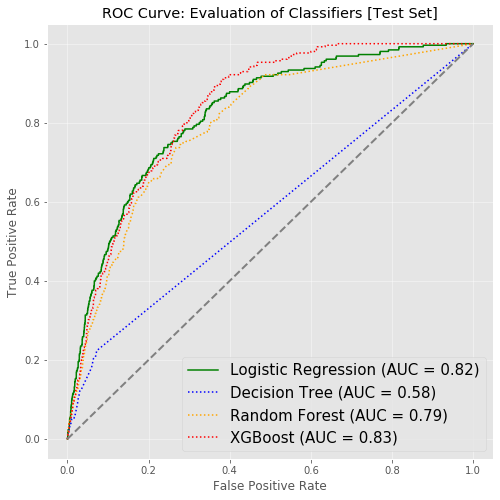

In [34]:
# plot a ROC-AUC curve
plt.figure(figsize=(8,8))
# ROC for each classifiers
colors = ['green', 'blue', 'orange', 'red']
linestyles = ['-', ':', ':', ':'] 
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):  
        # Assume the label of the positive class is 1
        y_pred = clf.fit(X_train_resampled,
                         y_train_resampled).predict_proba(X_val.values)[:,1]
        fpr, tpr, thresholds = skm.roc_curve(y_true=y_val, y_score=y_pred)
        roc_auc = skm.auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, color=clr, linestyle=ls,
                 label='%s (AUC = %0.2f)' % (label, roc_auc))
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(alpha=0.5)
plt.title('ROC Curve: Evaluation of Classifiers [Test Set]')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', prop={'size': 15})
plt.show()

## Summary of ROC Curve ##
This plot showed performance of all five models area under the curve. The best model had about AUC = 0.83 for XGBoost model. This indicated that about 83% of time model is good at separation of loan approved cases from non-approved cases.

# Part 4 - DEPLOY #

In [35]:
###########################
# Part 4 - DEPLOY PHASE ###
###########################
# --- 19. Automate the model pipeline --- #
# make predictions based on a test set
df_test_selected = enc_test_df.copy()
df_pred_probs = xgb.predict_proba(df_test_selected.values)

# make predictions dataframe:
results = pd.DataFrame({'ID':df_id_test,
                        'Approved':df_pred_probs[:,1]})
results.to_csv('prob_results_best_model.csv', index=False, index_label=None)

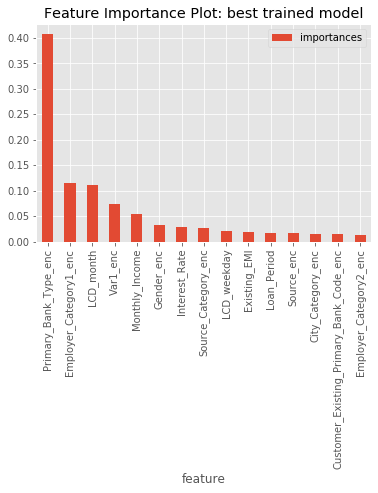

In [36]:
# --- 20. Deploy the solution --- #
#store feature importances
if hasattr(xgb, 'feature_importances_'):
    importances = xgb.feature_importances_
else:
# linear models don't have feature_importances_
    importances = [0]*len(X_train.columns)

# Create a feature importance df and sort by importances:
feature_importances = pd.DataFrame({'feature':X_train.columns,
                                    'importances':importances})
feature_importances.sort_values(by='importances', inplace=True, ascending=False)
    
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

#create a plot
feature_importances[0:15].plot.bar(align='center')
plt.title('Feature Importance Plot: best trained model')
plt.show()
    
#Save model results as .csv file:
model_results(model, mean_roc_auc[model], results, feature_importances)

## Model Summary: Feature Importance ##
A figure showed the feature importance on the best trained model from order of the highest to lowest feature importance ranks.

Top 10 important features were age followed by primary bank type, employer category1, Lead Creation Month, etc.